# EMNIST digit classification

## Test error rates of this model on EMNIST test data:
Model was trained from scratch on EMNIST Digits training data using realtime data augmentation.
### Dropout 0.2
* 0.16% test error rate with ensemble of 10 CNNs at 267 epochs (dropout\_0.2/weights/267epochs\_weights\_model\_?.pkl)
* 0.175% test error rate for best single model at 258 epochs (dropout\_0.2/weights/258epochs\_weights\_model\_7.pkl)

In [1]:
%matplotlib inline

In [2]:
import tensorflow as tf

In [3]:
sess = tf.InteractiveSession()

In [4]:
import keras.backend as K
K.set_image_data_format("channels_first")

import keras
import numpy as np

from keras.layers import Dense, Dropout, Conv2D, MaxPooling2D
from keras.layers import Flatten, Lambda, BatchNormalization
from keras.models import Sequential
from keras.optimizers import Adam as Adam
from keras.layers.advanced_activations import LeakyReLU

Using TensorFlow backend.


In [5]:
# used to save and load training histories
import pickle
from collections import defaultdict

import resource, sys

# we would reach recursion limit when saving training history otherwise
resource.setrlimit(resource.RLIMIT_STACK, (2**29,-1))
sys.setrecursionlimit(2**29 - 1)

# Load EMNIST Digits dataset
Introduced by https://arxiv.org/abs/1702.05373v1 downloaded from https://www.nist.gov/itl/iad/image-group/emnist-dataset (Matlab format dataset). The matlab format dataset can be conveniently imported with scipy.io.loadmat.

In [6]:
from scipy import io as spio

In [7]:
emnist = spio.loadmat("datasets/matlab/emnist-digits.mat")

In [8]:
# load training dataset
x_train = emnist["dataset"][0][0][0][0][0][0]
x_train = x_train.astype(np.float32)

# load training labels
y_train = emnist["dataset"][0][0][0][0][0][1]

In [9]:
# load test dataset
x_test = emnist["dataset"][0][0][1][0][0][0]
x_test = x_test.astype(np.float32)

# load test labels
y_test = emnist["dataset"][0][0][1][0][0][1]

In [10]:
# store labels for visualization
train_labels = y_train
test_labels = y_test

In [11]:
x_train.shape

(240000, 784)

In [12]:
y_train.shape

(240000, 1)

In [13]:
# normalize
x_train /= 255
x_test /= 255

In [14]:
x_train

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]], dtype=float32)

In [15]:
# reshape using matlab order
x_train = x_train.reshape(x_train.shape[0], 1, 28, 28, order="A")
x_test = x_test.reshape(x_test.shape[0], 1, 28, 28, order="A")

In [16]:
x_train.shape

(240000, 1, 28, 28)

In [17]:
y_train.shape

(240000, 1)

In [18]:
# labels should be onehot encoded
y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)

y_train.shape

(240000, 10)

## Verify we have imported the data correctly

In [19]:
# which sample to look at
samplenum = 5437

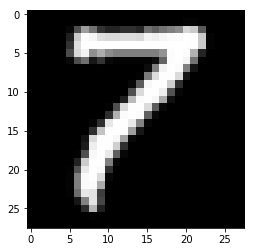

In [20]:
import matplotlib.pyplot as plt

img = x_train[samplenum]

# visualize image
plt.imshow(img[0], cmap='gray')

In [21]:
# show label for sample image
train_labels[samplenum][0]

7

## Reshape test labels

In [22]:
test_labels.shape

(40000, 1)

In [23]:
test_labels = test_labels.reshape(40000)

In [24]:
test_labels.shape

(40000,)

# Define model

In [25]:
# calculate mean and standard deviation
mean_px = x_train.mean().astype(np.float32)
std_px = x_train.std().astype(np.float32)

In [26]:
# function to normalize input data
def norm_input(x): return (x-mean_px)/std_px

In [27]:
# Batchnorm + dropout + data augmentation
def create_model():
    model = Sequential([
        Lambda(norm_input, input_shape=(1,28,28), output_shape=(1,28,28)),
        Conv2D(32, (3,3)),
        LeakyReLU(),
        BatchNormalization(axis=1),
        Conv2D(32, (3,3)),
        LeakyReLU(),
        MaxPooling2D(),
        BatchNormalization(axis=1),
        Conv2D(64, (3,3)),
        LeakyReLU(),
        BatchNormalization(axis=1),
        Conv2D(64, (3,3)),
        LeakyReLU(),
        MaxPooling2D(),
        Flatten(),
        BatchNormalization(),
        Dense(512),
        LeakyReLU(),
        BatchNormalization(),
        Dropout(0.2),
        Dense(10, activation='softmax')
    ])
    model.compile(Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Data augmentation
Use keras data augmentation.

In [28]:
batch_size = 512

In [29]:
from keras.preprocessing.image import ImageDataGenerator

In [30]:
gen = ImageDataGenerator(rotation_range=12, width_shift_range=0.1, shear_range=0.3,
                        height_shift_range=0.1, zoom_range=0.1, data_format='channels_first')
batches = gen.flow(x_train, y_train, batch_size=batch_size)
test_batches = gen.flow(x_test, y_test, batch_size=batch_size)
steps_per_epoch = int(np.ceil(batches.n/batch_size))
validation_steps = int(np.ceil(test_batches.n/batch_size))

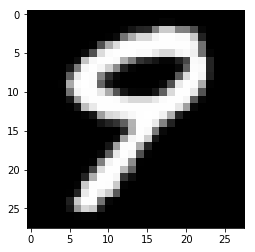

In [31]:
import matplotlib.pyplot as plt

# load ONE image from training set to display on screen
img = x_train[1]

# visualize original image
plt.imshow(img[0], cmap='gray')

In [32]:
# trick our generator into believing img has enough dimensions
# and get some augmented images for our single test image
img = np.expand_dims(img, axis=0)
aug_iter = gen.flow(img)

In [33]:
aug_img = next(aug_iter)[0].astype(np.float32)
aug_img.shape

(1, 28, 28)

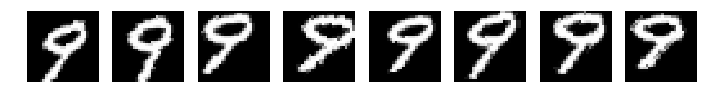

In [34]:
import matplotlib.pyplot as plt

# show augmented images
f = plt.figure(figsize=(12,6))
for i in range(8):
    sp = f.add_subplot(2, 26//3, i+1)
    sp.axis('Off')
    aug_img = next(aug_iter)[0].astype(np.float32)
    plt.imshow(aug_img[0], cmap='gray')

# Ensembling
Here we create ten models and fit them to our augmented data. We use the mean prediction from all ten classifiers as our final prediction. This should average out errors in our classifiers and enable us to predict with higher accuracy.

## Create ten models from scratch

In [35]:
models = []
weights_epoch = 0

for i in range(10):
    m = create_model()
    models.append(m)

## Or Create ten models using saved weights

In [36]:
# specify which weights to load
weights_epoch = 267

In [37]:
models = []

for i in range(10):
    m = create_model()
    m.load_weights('dropout_0.2/weights/{:03d}epochs_weights_model_{}.pkl'.format(weights_epoch, i))
    models.append(m)

## Train models for a few more epochs
Train models for some additional epochs and save model weights as well as corresponding training history every num_epochs. Test error rates for ensemble and every single model are written to text files after every iteration.

In [95]:
eval_batch_size = 512

In [96]:
# how many iterations with how many epochs we want to train
num_iterations = 1
num_epochs = 1

In [97]:
for iteration in range(num_iterations):
    cur_epoch = (iteration+1)*num_epochs + weights_epoch
    print("iteration {}, cur_epoch {}".format(iteration+1, cur_epoch))
    
    # train models for specified number of epochs
    for i,m in enumerate(models):
        m.optimizer.lr = 0.000001
        h = m.fit_generator(batches, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=0,
                            validation_data=test_batches, validation_steps=validation_steps)
        
        # save model weights
        m.save_weights("dropout_0.2/weights/{:03d}epochs_weights_model_{}.pkl".format(cur_epoch, i))
        
        # save corresponding training history (broken right now)
        # TypeError: can't pickle _thread.lock objects
        #with open("dropout_0.2/history/{:03d}epochs_history_model_{}.pkl".format(cur_epoch, i),"wb") as f:
        #    pickle.dump(h, f)
        
    # evaluate test error rate for ensemble
    all_preds = np.stack([m.predict(x_test, batch_size=eval_batch_size) for m in models]) 
    avg_preds = all_preds.mean(axis=0)
    test_error_ensemble = (1 - keras.metrics.categorical_accuracy(y_test, avg_preds).eval().mean()) * 100
    
    # write test error rate for ensemble and every single model to text file
    with open("dropout_0.2/history/test_errors_epoch_{:03d}.txt".format(cur_epoch), "w") as text_file:
        text_file.write("epoch: {} test error on ensemble: {}\n".format(cur_epoch, test_error_ensemble))

        for m in models:
            pred = np.array(m.predict(x_test, batch_size=eval_batch_size))
            test_err = (1 - keras.metrics.categorical_accuracy(y_test, pred).eval().mean()) * 100
            text_file.write("{}\n".format(test_err))

iteration 1, cur_epoch 268


# Evaluate Ensemble of 10 CNNs

In [38]:
eval_batch_size = 512

In [39]:
all_preds = np.stack([m.predict(x_test, batch_size=eval_batch_size) for m in models])

In [40]:
avg_preds = all_preds.mean(axis=0)

In [41]:
# display error rate in percent
(1 - keras.metrics.categorical_accuracy(y_test, avg_preds).eval().mean()) * 100

0.16000270843505859

## Show test error rate of every model separately
All test error rates in percent.

In [42]:
for i, m in enumerate(models):
    pred = np.array(m.predict(x_test, batch_size=eval_batch_size))
    print(i+1, (1 - keras.metrics.categorical_accuracy(y_test, pred).eval().mean()) * 100)

1 0.204998254776
2 0.212502479553
3 0.199997425079
4 0.197499990463
5 0.209999084473
6 0.204998254776
7 0.217497348785
8 0.199997425079
9 0.185000896454
10 0.207501649857


# Plot Training History

Load and plot saved training histories. Utility functions from https://github.com/fchollet/keras/issues/103
Prepending zeros to history files with
<pre>
for i in `find * | grep "^..epo"`; do mv $i 0$i; done
</pre>

In [39]:
# which model to plot training history of
i = 9

In [40]:
# merge training histories
def merge_dict(dict_list):
    dd = defaultdict(list)    
    for d in dict_list:
        for key, value in d.items():
            if not hasattr(value, '__iter__'):
                value = (value,)       
            [dd[key].append(v) for v in value]
    return dict(dd)

# load pickled data
def load(name):
    filename = open(name,"rb")
    obj = pickle.load(filename)
    filename.close()    
    return(obj)

In [41]:
import glob
histories = glob.glob("dropout_0.2/history/*model_{}*".format(i))

In [42]:
histories = sorted(histories)

In [43]:
histories

['dropout_0.2/history/016epochs_history_model_9.pkl',
 'dropout_0.2/history/032epochs_history_model_9.pkl',
 'dropout_0.2/history/048epochs_history_model_9.pkl',
 'dropout_0.2/history/064epochs_history_model_9.pkl',
 'dropout_0.2/history/080epochs_history_model_9.pkl',
 'dropout_0.2/history/096epochs_history_model_9.pkl',
 'dropout_0.2/history/112epochs_history_model_9.pkl',
 'dropout_0.2/history/128epochs_history_model_9.pkl',
 'dropout_0.2/history/144epochs_history_model_9.pkl',
 'dropout_0.2/history/160epochs_history_model_9.pkl',
 'dropout_0.2/history/176epochs_history_model_9.pkl',
 'dropout_0.2/history/192epochs_history_model_9.pkl',
 'dropout_0.2/history/208epochs_history_model_9.pkl',
 'dropout_0.2/history/224epochs_history_model_9.pkl',
 'dropout_0.2/history/240epochs_history_model_9.pkl',
 'dropout_0.2/history/256epochs_history_model_9.pkl',
 'dropout_0.2/history/272epochs_history_model_9.pkl',
 'dropout_0.2/history/288epochs_history_model_9.pkl',
 'dropout_0.2/history/304epo

In [ ]:
# first history would include zero accuracy and mess up our plot
h0 = load(histories[1])

In [ ]:
# merge all saved histories
for h in histories[2:]:
    h1 = load(h)
    h0.history = merge_dict([h0.history,h1.history])

In [ ]:
history = h0

In [ ]:
min = np.argmin(history)

Jason Brownlee's script to plot model training history:
https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


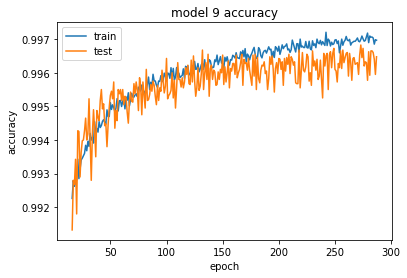

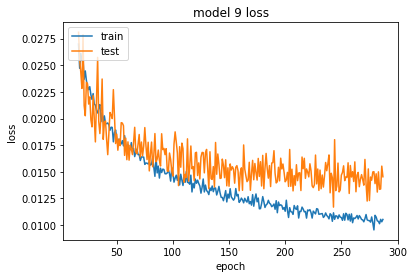

In [48]:
import matplotlib.pyplot as plt

axes = plt.gca()

# set x label range, starting with 16
r = np.arange(16,288)

# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(r, history.history['acc'])
plt.plot(r, history.history['val_acc'])
plt.title("model {} accuracy".format(i))
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
#plt.xlim(32,224)
plt.show()

# summarize history for loss
plt.plot(r, history.history['loss'])
plt.plot(r, history.history['val_loss'])
plt.title("model {} loss".format(i))
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
#plt.xlim(32,224)
plt.show()

# Try evaluation only with best performing models
Most of the time, this does not improve prediction accuracy.
<pre>
267 epochs, dropout 0.2
0 0.204998254776
1 0.212502479553
2 0.199997425079
3 0.197499990463
4 0.209999084473
5 0.204998254776
6 0.217497348785
7 0.199997425079
8 0.185000896454
9 0.207501649857
</pre>

In [150]:
best_model_numbers = [2,3,7,8]

In [151]:
best_models = []

for i in best_model_numbers:
    best_models.append(models[i])

In [152]:
all_preds = np.stack([m.predict(x_test, batch_size=eval_batch_size) for m in best_models])

In [153]:
avg_preds = all_preds.mean(axis=0)

In [154]:
# display error rate in percent
(1 - keras.metrics.categorical_accuracy(y_test, avg_preds).eval().mean()) * 100

0.17250180244445801

# Train single model some more

Select a single model, train for a few epochs, and check accuracy.

In [ ]:
# which model to train
i = 8

In [ ]:
# reload weights in case of overfitting
# models[i].load_weights("weights/weights_emnist_model_0.2475_"+str(i)+'.pkl')

In [ ]:
models[i].optimizer.lr = 0.0001
history = models[i].fit_generator(batches, steps_per_epoch=steps_per_epoch, epochs=4,
                   validation_data=test_batches, validation_steps=validation_steps)

In [ ]:
# calculate accuracy of single model
pred = np.array(models[i].predict(x_test, batch_size=eval_batch_size))
print(i, (1 - keras.metrics.categorical_accuracy(y_test, pred).eval().mean()) * 100)

In [ ]:
# models[i].save_weights("weights/weights_emnist_model_0.2475_"+str(i)+'.pkl')

# Visualize model

In [57]:
models[0].summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_1 (Lambda)            (None, 1, 28, 28)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 26, 26)        320       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 32, 26, 26)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 26, 26)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 24, 24)        9248      
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 32, 24, 24)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 12, 12)        0         
__________

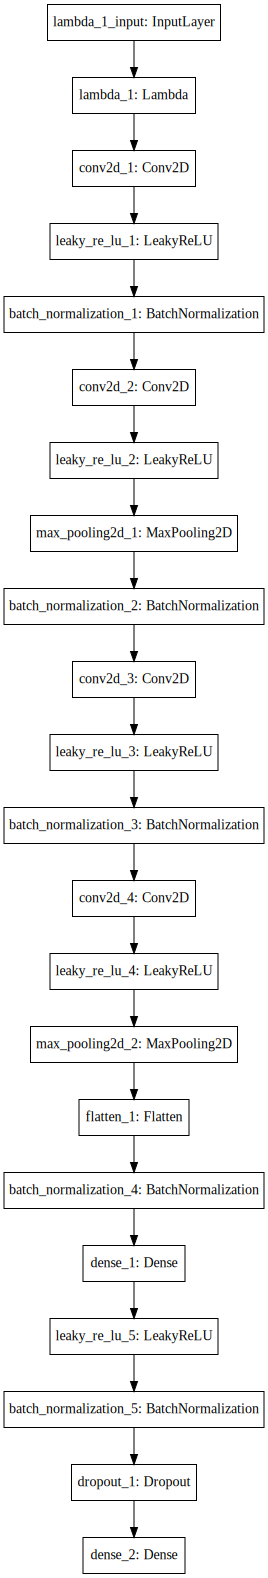

In [58]:
# fix for python3
import pydotplus as pydot

from keras.utils import plot_model
plot_model(models[0], to_file='model.png')

# visualize our model
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
SVG(model_to_dot(models[0]).create(prog='dot', format='svg'))

# Visualize Predictions
Here we compute the predictions from a single model or ensemble to visualize them later. As well as looking at the overall metrics, it's also a good idea to look at examples of:
1. A few correct labels at random
2. A few incorrect labels at random

## Compute predictions for best performing single model

In [45]:
m = create_model()

In [46]:
# load saved weights
m.load_weights("dropout_0.2/weights/258epochs_weights_model_7.pkl")

In [47]:
# predict classes
preds = m.predict_classes(x_test, batch_size=eval_batch_size)

37888/40000 [===========================>..] - ETA: 0s

In [48]:
preds.shape

(40000,)

## Or compute predictions for ensemble
Load model weights and compute predictions.

In [43]:
# specify which weights to load
weights_epoch = 267
dropout = "0.2"

In [44]:
models = []

for i in range(10):
    m = create_model()
    m.load_weights('dropout_{}/weights/{:3d}epochs_weights_model_{}.pkl'.format(dropout, weights_epoch, i))
    models.append(m)

In [45]:
all_preds = np.stack([m.predict(x_test, batch_size=eval_batch_size) for m in models])

In [46]:
avg_preds = all_preds.mean(axis=0)

In [47]:
# decode a one hot encoded string
def one_hot_decode(encoded_seq):
    return [np.argmax(vector) for vector in encoded_seq]

In [48]:
preds = np.array(one_hot_decode(avg_preds))

In [49]:
preds.shape

(40000,)

In [50]:
# display error rate in percent to check we have loaded the weights we wanted
(1 - keras.metrics.categorical_accuracy(y_test, avg_preds).eval().mean()) * 100

0.16000270843505859

## Visualize computed predictions

In [51]:
test_labels.shape

(40000,)

In [52]:
correct = np.where(preds==test_labels)[0]

In [53]:
incorrect = np.where(preds!=test_labels)[0]

In [54]:
correct.shape

(39936,)

In [55]:
incorrect.shape

(64,)

In [56]:
# number of images to view
n_view = incorrect.shape[0]

In [57]:
from numpy.random import permutation

# get a random selection of correctly predicted images
idx = permutation(correct)[:n_view]
idx_incorrect = incorrect[:n_view]

In [58]:
preds_correct = preds[idx]
preds_incorrect = preds[idx_incorrect]

In [59]:
imgs = x_test[idx]
imgs_incorrect = x_test[idx_incorrect]

In [60]:
imgs.shape

(64, 1, 28, 28)

## A few correct labels at random

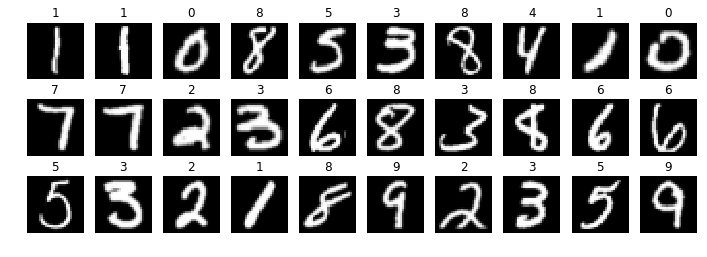

In [61]:
f = plt.figure(figsize=(12,4))

for i in range(30):
    sp = f.add_subplot(3, 10, i+1)
    sp.axis('Off')
    sp.set_title(preds_correct[i])
    img = imgs[i].astype('float32')
    plt.imshow(img[0], cmap='gray')

In [62]:
# ground truth labels
test_labels[idx]

array([1, 1, 0, 8, 5, 3, 8, 4, 1, 0, 7, 7, 2, 3, 6, 8, 3, 8, 6, 6, 5, 3, 2,
       1, 8, 9, 2, 3, 5, 9, 9, 4, 9, 0, 4, 3, 2, 7, 9, 1, 2, 0, 7, 0, 3, 8,
       0, 8, 7, 3, 3, 6, 5, 7, 8, 9, 3, 5, 9, 9, 0, 0, 7, 2], dtype=uint8)

## All incorrect labels
Display all predictions not matching ground truth. There are clearly some labeling errors in EMNIST Digits, limiting our overall prediction accuracy.

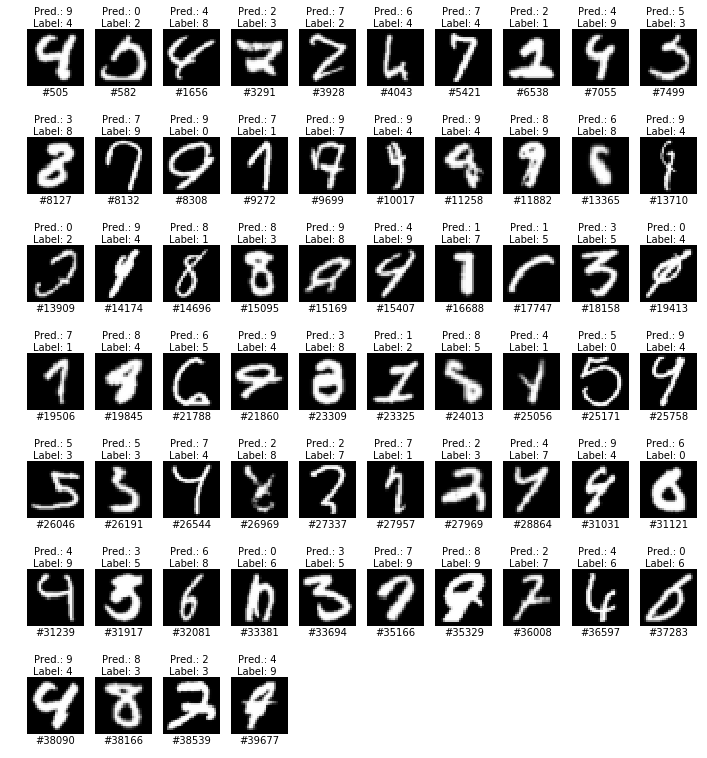

In [68]:
f = plt.figure(figsize=(12,10))

plt.subplots_adjust(left=None, bottom=None, right=None, top=1.15,
                wspace=None, hspace=None)

for i in range(n_view): 
    sp = f.add_subplot(7, 10, i+1)
    sp.axis('Off')
    sp.text(0.8, 1.2, "Pred.: {}\nLabel: {}"
                 .format(preds_incorrect[i],test_labels[idx_incorrect][i]),
            horizontalalignment='right', verticalalignment='center',
            transform=sp.transAxes)
    plt.text(0.5, -0.12, "#{}".format(idx_incorrect[i]), 
             horizontalalignment='center', verticalalignment='center',
             transform=sp.transAxes)
    img = imgs_incorrect[i].astype('float32')
    plt.imshow(img[0], cmap='gray')

In [69]:
# ground truth labels
test_labels[idx_incorrect]

array([4, 2, 8, 3, 2, 4, 4, 1, 9, 3, 8, 9, 0, 1, 7, 4, 4, 9, 8, 4, 2, 4, 1,
       3, 8, 9, 7, 5, 5, 4, 1, 4, 5, 4, 8, 2, 5, 1, 0, 4, 3, 3, 4, 8, 7, 1,
       3, 7, 4, 0, 9, 5, 8, 6, 5, 9, 9, 7, 6, 6, 4, 3, 3, 9], dtype=uint8)

In [70]:
idx_incorrect

array([  505,   582,  1656,  3291,  3928,  4043,  5421,  6538,  7055,
        7499,  8127,  8132,  8308,  9272,  9699, 10017, 11258, 11882,
       13365, 13710, 13909, 14174, 14696, 15095, 15169, 15407, 16688,
       17747, 18158, 19413, 19506, 19845, 21788, 21860, 23309, 23325,
       24013, 25056, 25171, 25758, 26046, 26191, 26544, 26969, 27337,
       27957, 27969, 28864, 31031, 31121, 31239, 31917, 32081, 33381,
       33694, 35166, 35329, 36008, 36597, 37283, 38090, 38166, 38539, 39677])

# Print confusion matrix

Plot unnormalized and normalized confusion matrices. Code adapted from 
http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html


In [97]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [98]:
# calculate confusion matrix
from sklearn.metrics import confusion_matrix
cnf_matrix = confusion_matrix(test_labels, preds)

Confusion matrix, without normalization
[[3997    0    0    0    0    1    1    0    0    1]
 [   0 3994    1    0    1    0    0    3    1    0]
 [   2    1 3996    0    0    0    0    1    0    0]
 [   0    0    3 3992    0    3    0    0    2    0]
 [   1    0    0    0 3986    0    1    2    1    9]
 [   0    1    0    3    0 3994    1    0    1    0]
 [   2    0    0    0    1    0 3997    0    0    0]
 [   0    1    2    0    1    0    0 3995    0    1]
 [   0    0    1    2    1    0    2    0 3993    1]
 [   0    0    0    0    4    0    0    2    2 3992]]
Normalized confusion matrix
[[  9.99e-01   0.00e+00   0.00e+00   0.00e+00   0.00e+00   2.50e-04
    2.50e-04   0.00e+00   0.00e+00   2.50e-04]
 [  0.00e+00   9.99e-01   2.50e-04   0.00e+00   2.50e-04   0.00e+00
    0.00e+00   7.50e-04   2.50e-04   0.00e+00]
 [  5.00e-04   2.50e-04   9.99e-01   0.00e+00   0.00e+00   0.00e+00
    0.00e+00   2.50e-04   0.00e+00   0.00e+00]
 [  0.00e+00   0.00e+00   7.50e-04   9.98e-01   0.00e+00

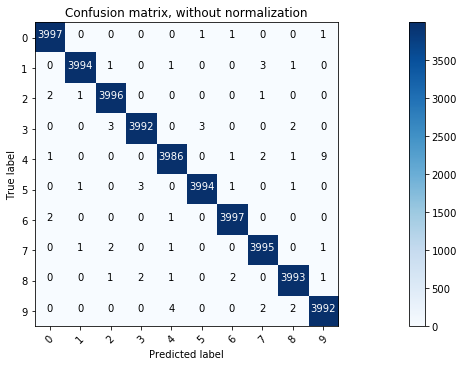

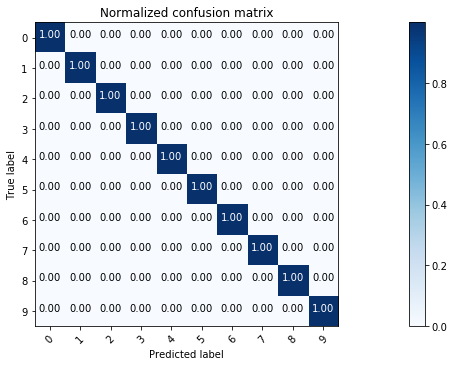

In [99]:
import itertools

class_names = [i for i in range(10)]
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(20,5))
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure(figsize=(20,5))
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()